In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from models import *
from sklearn import metrics

TensorFlow Version: 1.9.0
Keras      Version: 2.2.0


Using TensorFlow backend.


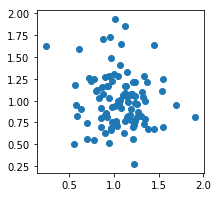

In [2]:
def build_2d_data(N, beta=0.1):
    """ 
    2d, Mulitvariate Guassian data
    """
    mu = [1, 1]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        x[n, :] = np.random.multivariate_normal(mu, Sigma)
        
    return x
X = build_2d_data(100)
plt.figure(figsize=(3,3))
plt.scatter(X[:,0], X[:, 1])

In [3]:
D = 2
X_train = X[0:-1]; y_train = X[1:]

Now, we define some toy problem

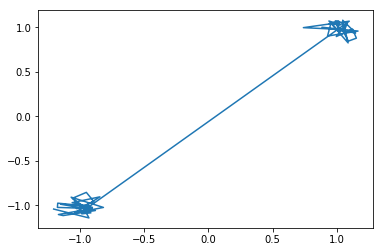

In [4]:
# first demo -- gaussian mixture defined by the CRP

def build_static_dataset(N, beta=0.1):
    """ 
    2 events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/2):
        x[n, :] = np.random.multivariate_normal(mus[0], np.eye(2) * beta)
    for n in range(N/2, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.eye(2) * beta)
        
    return x

x_train = build_static_dataset(50, 0.01)
y = np.concatenate([np.zeros((25), dtype=int), np.ones((25), dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

In [5]:
# SEM parameters
lmda = 10.0  # stickyness parameter
alfa = .01  # concentration parameter

# prior over the event varaiance 
var_scale = 0.4
var_df = 10

# define plotting function
import seaborn as sns

def plot_segmentation(post, y):
    cluster_id = np.argmax(post, axis=1)
    cc = sns.color_palette('Dark2', post.shape[1])
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
    for clt in cluster_id:
        idx = np.nonzero(cluster_id == clt)[0]
        axes[0].scatter(x_train[idx, 0], x_train[idx, 1], color=cc[clt], alpha=.5)
    axes[0].set_xlabel(r'$\mathbf{x}_{s,1}$')
    axes[0].set_ylabel(r'$\mathbf{x}_{s,2}$')


    axes[1].plot(post)
    y_hat = np.argmax(post, axis=1)
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Cluster ID')
    print "Adjusted Mutual Information:", metrics.adjusted_mutual_info_score(y, y_hat)
    print "Adjusted Rand Score:", metrics.adjusted_rand_score(y, y_hat)
    print 
    print np.argmax(post, axis=1)

### Linear Events 

Run SEM: 100%|██████████| 50/50 [00:01<00:00, 33.39it/s]


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


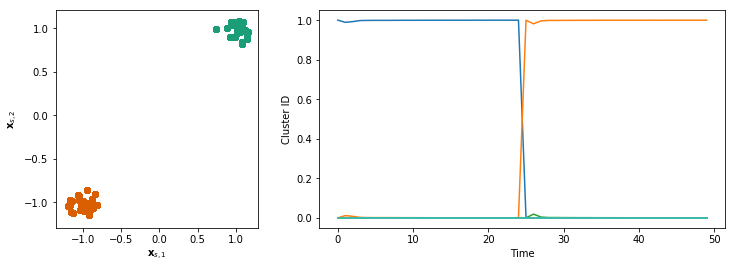

In [6]:
# Initialize keras model
sem_kwargs2 = dict(
    lmda=lmda, alfa=alfa, f_class=LinearEvent, 
    f_opts=dict(var_scale0=var_scale, var_df0=var_df, l2_regularization=0.4)
)

sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Non-linear Events

Run SEM: 100%|██████████| 50/50 [00:02<00:00, 18.51it/s]


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


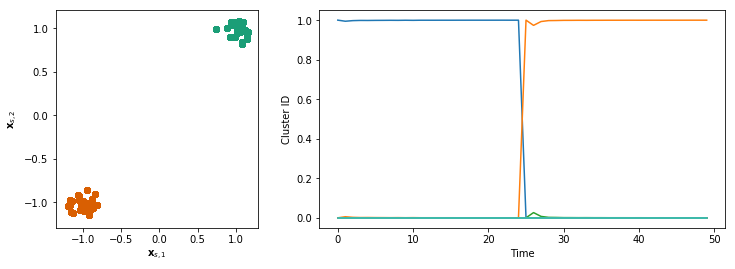

In [7]:
# Initialize keras model
sem_kwargs3 = dict(
    lmda=lmda, alfa=alfa, f_class=NonLinearEvent,
    f_opts=dict(var_scale0=var_scale, var_df0=var_df)
)

sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

###  Recurrent Linear Events

Run SEM: 100%|██████████| 50/50 [00:03<00:00, 13.65it/s]


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


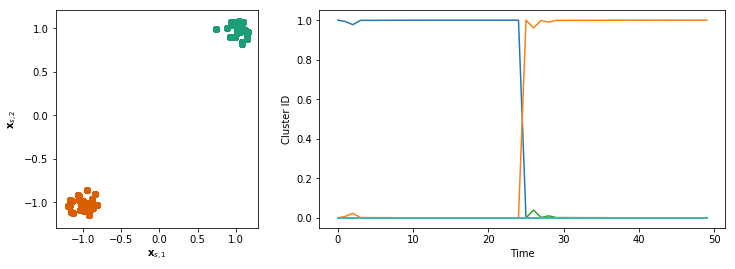

In [8]:
# Initialize keras model
sem_kwargs4 = dict(
    lmda=lmda, alfa=alfa, f_class=RecurentLinearEvent, 
    f_opts=dict(t=3, var_scale0=var_scale, var_df0=var_df)
)

sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Non-linear Events

Run SEM: 100%|██████████| 50/50 [00:05<00:00,  8.36it/s]


Adjusted Mutual Information: 0.8884438864742173
Adjusted Rand Score: 0.9607686148919136

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]


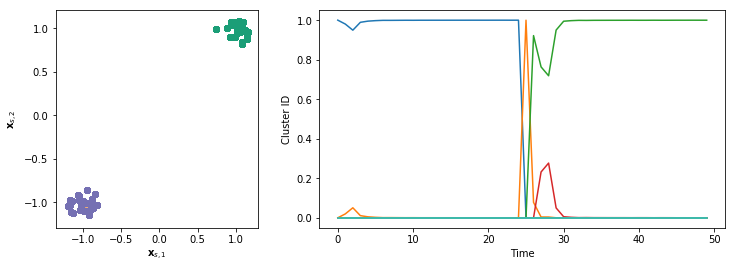

In [9]:
sem_kwargs5 = dict(
    lmda=lmda, alfa=alfa, f_class=RecurrentEvent,
    f_opts=dict(t=3, var_scale0=var_scale, var_df0=var_df)
               )

sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Gated Recurrent Unit Events

Run SEM: 100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


Adjusted Mutual Information: 0.7966523878990056
Adjusted Rand Score: 0.9231128768403832

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]


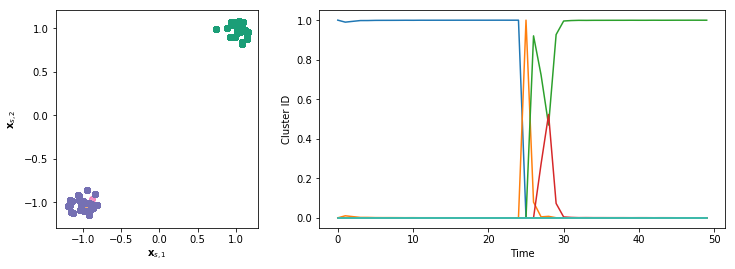

In [10]:
sem_kwargs6 = dict(
    lmda=lmda, alfa=alfa, f_class=GRUEvent,
    f_opts=dict(t=3, var_scale0=var_scale, var_df0=var_df)
               )

sem6 = SEM(**sem_kwargs6)
post = sem6.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### LSTM Events

Run SEM: 100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


Adjusted Mutual Information: 0.8884438864742173
Adjusted Rand Score: 0.9607686148919136

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]


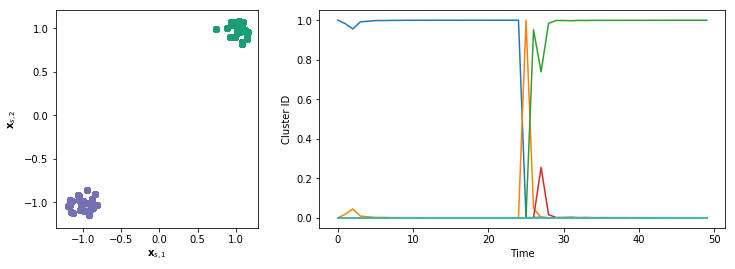

In [11]:
sem_kwargs7 = dict(
    lmda=lmda, alfa=alfa, f_class=LSTMEvent,
    f_opts=dict(t=3, var_scale0=var_scale, var_df0=var_df)
               )

sem7 = SEM(**sem_kwargs7)
post = sem7.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

# Alternating between 2 static events


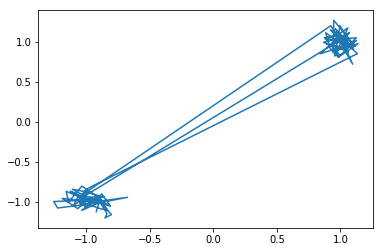

In [12]:
def build_alternating_static_events(N, beta=0.1):
    """ 
    2 alternating events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/4):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4, N/2):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
    for n in range(N/2, N/4*3):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4*3, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
        
    return x

x_train = build_alternating_static_events(100, 0.01)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), np.zeros(25, dtype=int), np.ones(25, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear Events 

Run SEM: 100%|██████████| 100/100 [00:05<00:00, 17.89it/s]


Adjusted Mutual Information: 0.6633529024545869
Adjusted Rand Score: 0.7468030690537084

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


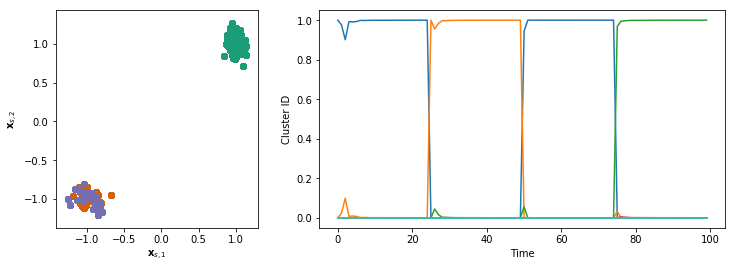

In [13]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:05<00:00, 18.05it/s]


Adjusted Mutual Information: 0.6633529024545869
Adjusted Rand Score: 0.7468030690537084

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


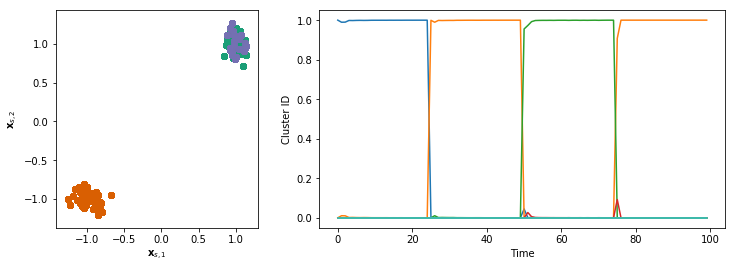

In [14]:
sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Linear Events

Run SEM: 100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


Adjusted Mutual Information: 0.43259529703347505
Adjusted Rand Score: 0.44749930239810914

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 1 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


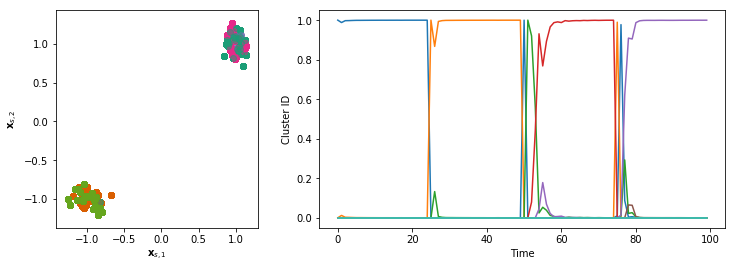

In [15]:
sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Adjusted Mutual Information: 0.4635872088697424
Adjusted Rand Score: 0.47241264722895726

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


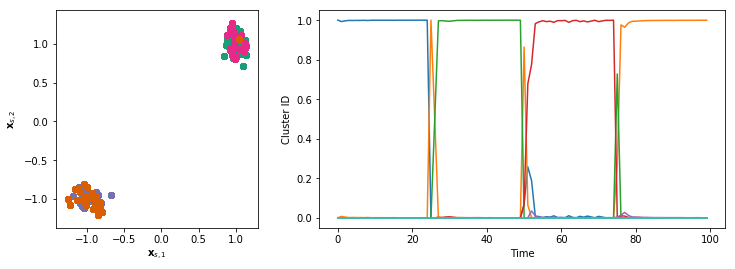

In [16]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### GRU Events

Run SEM: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


Adjusted Mutual Information: 0.39032376957005976
Adjusted Rand Score: 0.42513901142868865

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 2 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


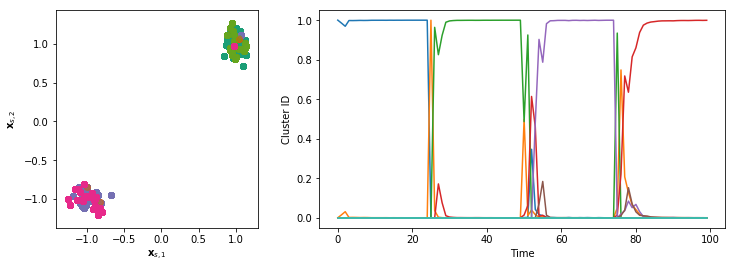

In [17]:
sem6 = SEM(**sem_kwargs6)
post = sem6.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### LSTM Events

Run SEM: 100%|██████████| 100/100 [00:25<00:00,  4.00it/s]


Adjusted Mutual Information: 0.39032376957005976
Adjusted Rand Score: 0.42513901142868865

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 2 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


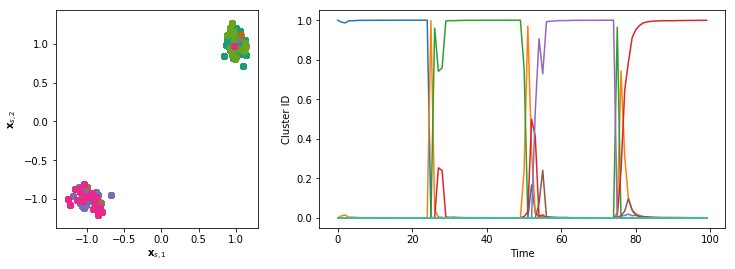

In [18]:
sem7 = SEM(**sem_kwargs7)
post = sem7.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

# Example of four events where the events correspond to movement in vector space

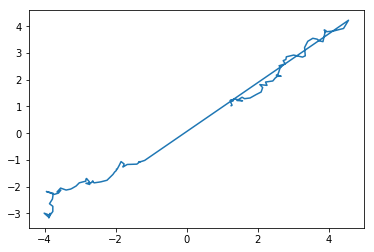

In [19]:
def build_moving_data(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    stds = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], stds)
    for n in range(1, N/2):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
        
    x[N/2, :] = np.random.multivariate_normal(bs[1], stds)
    for n in range(N/2+1, N):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
    return x

x_train = build_moving_data(100)
y = np.concatenate([np.zeros(50, dtype=int), np.ones(50, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear Events 

Run SEM: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Adjusted Mutual Information: 0.6450492929828261
Adjusted Rand Score: 0.8490477338969125

[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 3 4 5 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


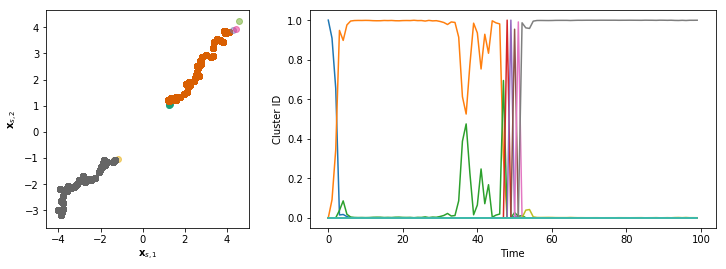

In [20]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Adjusted Mutual Information: 0.2189900076438711
Adjusted Rand Score: 0.25947750852245854

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  1  2  3  4  5  6  6  6  6  6  6  6  6  6  6  7  6  6  6  6  6  7
  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 22 22 22 22 23 23 22 22 22
 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 24 25 26 27 28 28 28 28 28
 28 28 28 28]


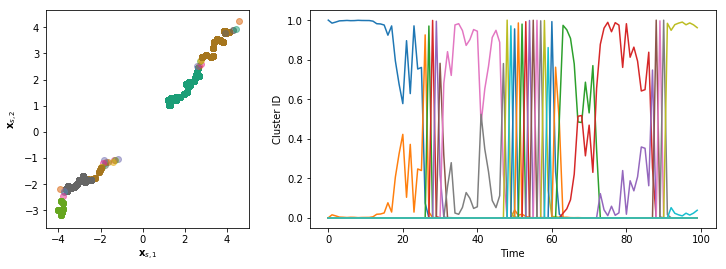

In [21]:
sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Linear Events

Run SEM: 100%|██████████| 100/100 [00:12<00:00,  7.85it/s]


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


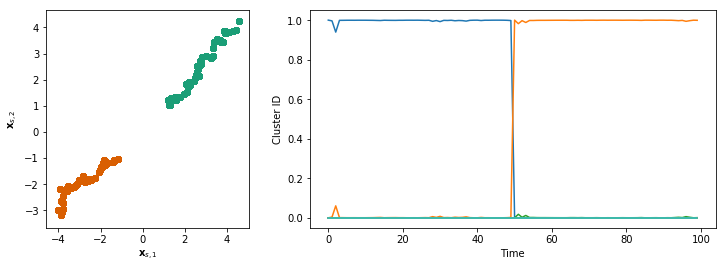

In [22]:
sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Non-linear Events

Run SEM: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Adjusted Mutual Information: 0.24639972447152592
Adjusted Rand Score: 0.21762472282673534

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  3  4  5  6  7  8  9  9 10 11 12 12 12 13 13 14 15 15 16 16 16 16
 16 16 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19]


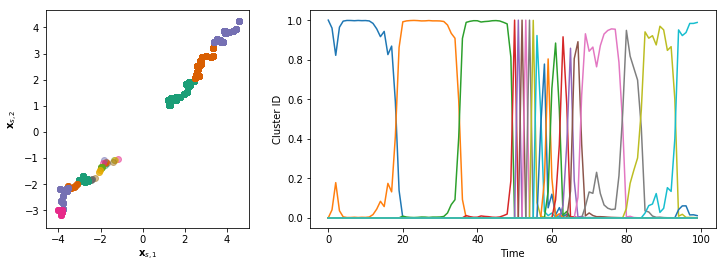

In [23]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### GRU Events

Run SEM: 100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Adjusted Mutual Information: 0.23486210160452714
Adjusted Rand Score: 0.20120227617789738

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  3  4  5  6  7  8  8  9 10 10 11 11 12 12 12 13 14 15 15 16 16 16
 16 17 17 17 17 17 17 17 18 18 18 18 18 19 19 19 19 19 19 19 19 19 20 20
 20 20 20 20]


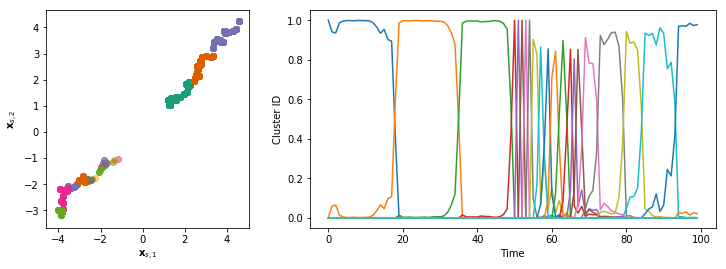

In [24]:
sem6 = SEM(**sem_kwargs6)
post = sem6.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### LSTM Events

Run SEM: 100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


Adjusted Mutual Information: 0.24476709648273914
Adjusted Rand Score: 0.24758175955780745

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2
  2  2  3  4  5  6  7  8  9 10 11 12 13 14 15 15 16 16 17 17 18 18 19 19
 19 19 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 20 21 21 21
 21 21 21 21]


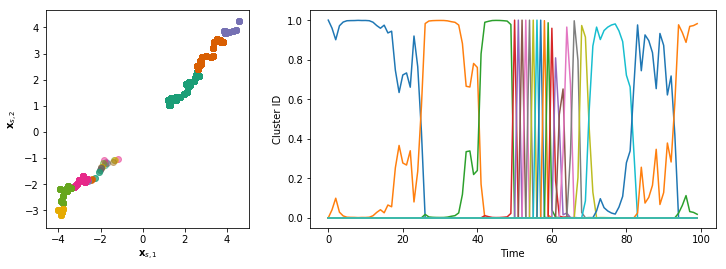

In [25]:
sem7 = SEM(**sem_kwargs7)
post = sem7.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

# Two alternating events with different levels of noise (10x)

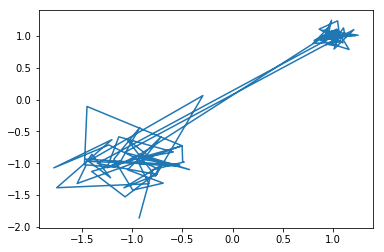

In [26]:
def build_alternating_static_events(N, beta=0.1):
    """ 
    2 alternating events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.array([beta, beta * 10.])
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/4):
        x[n, :] = np.random.multivariate_normal(mus[0], np.eye(2) * stds[0])
    for n in range(N/4, N/2):
        x[n, :] = np.random.multivariate_normal(mus[1], np.eye(2) * stds[1])
    for n in range(N/2, N/4*3):
        x[n, :] = np.random.multivariate_normal(mus[0], np.eye(2) * stds[0])
    for n in range(N/4*3, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.eye(2) * stds[1])
        
    return x

x_train = build_alternating_static_events(100, 0.01)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), np.zeros(25, dtype=int), np.ones(25, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear Events

Run SEM: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Adjusted Mutual Information: 0.5749538732263748
Adjusted Rand Score: 0.6876562659846547

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


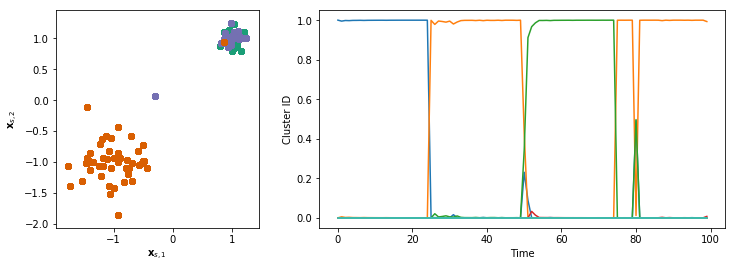

In [27]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


Adjusted Mutual Information: 0.8076009635286463
Adjusted Rand Score: 0.908998059442345

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


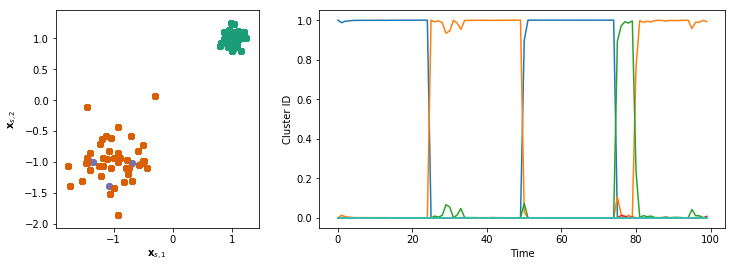

In [28]:
sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Linear Events

Run SEM: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


Adjusted Mutual Information: 0.355915730399704
Adjusted Rand Score: 0.3079630444346678

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


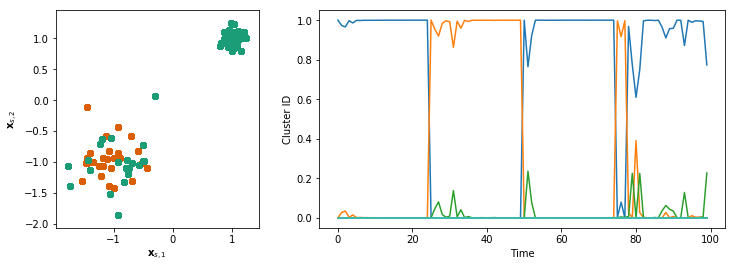

In [29]:
sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


Adjusted Mutual Information: 0.43091317642978566
Adjusted Rand Score: 0.5693395376271854

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 2 1 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


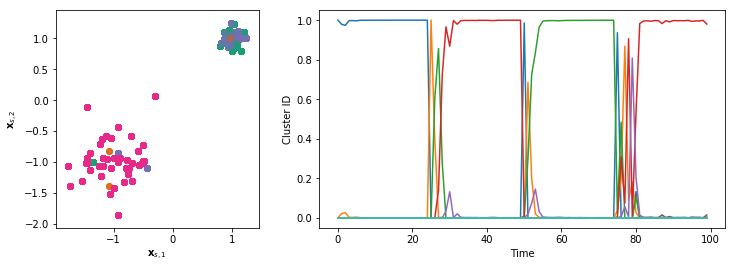

In [30]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### GRU Events

Run SEM: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Adjusted Mutual Information: 0.31815440116949933
Adjusted Rand Score: 0.3651397088406999

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 2 1 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 2 1 6 3 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


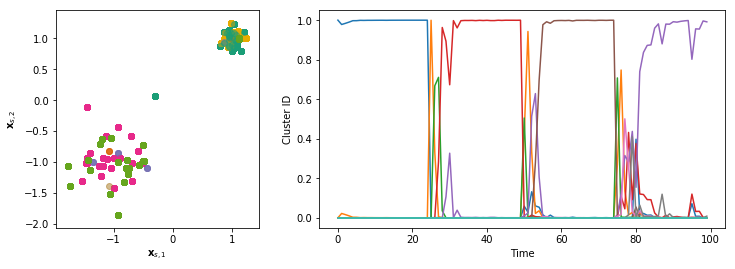

In [31]:
sem6 = SEM(**sem_kwargs6)
post = sem6.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### LSTM Events

Run SEM: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


Adjusted Mutual Information: 0.44365917809776595
Adjusted Rand Score: 0.5645417167125107

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 2 1 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 2 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


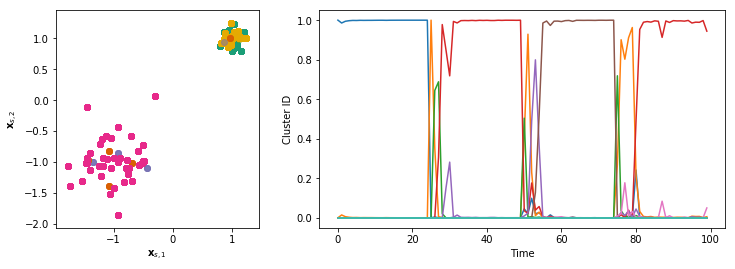

In [32]:
sem7 = SEM(**sem_kwargs7)
post = sem7.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

# 4 events where the events correspond to movement in vector space


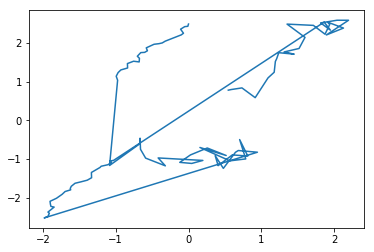

In [33]:
def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigmas = [np.eye(2) * beta* 5.,
            np.eye(2) * beta / 5.,
            np.eye(2) * beta * 5.,
            np.eye(2) * beta / 5.]
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigmas[0])
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigmas[0])
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigmas[1])
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigmas[1])
            
    x[N/2, :] = np.random.multivariate_normal(bs[2], Sigmas[2])
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigmas[2])
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[3], Sigmas[3])
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigmas[3])      
        
    return x

x_train = build_alternating_moving_events(100)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), 
                    np.ones(25, dtype=int)*2, np.ones(25, dtype=int)*3])

plt.plot(x_train[:, 0], x_train[:, 1])

### Linear Events

Run SEM: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


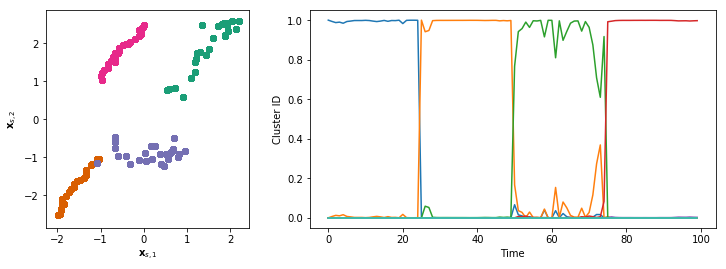

In [34]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


Adjusted Mutual Information: 0.9683485027799984
Adjusted Rand Score: 0.97305763367046

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


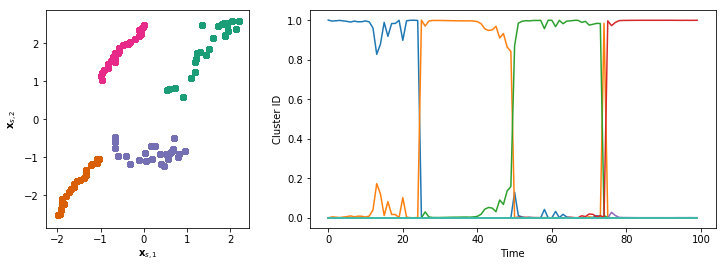

In [35]:
sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Linear Events

Run SEM: 100%|██████████| 100/100 [00:24<00:00,  4.06it/s]


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


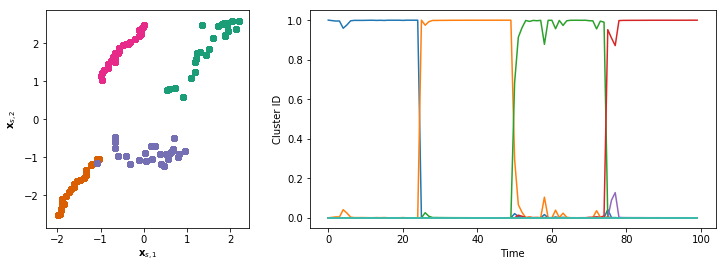

In [36]:
sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent Non-linear Events

Run SEM: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Adjusted Mutual Information: 0.6607998095134892
Adjusted Rand Score: 0.712161336321043

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 3 4 5 5 6 6 6 6 6 6 6
 6 6 6 6 7 7 7 7 7 7 7 7 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 6 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


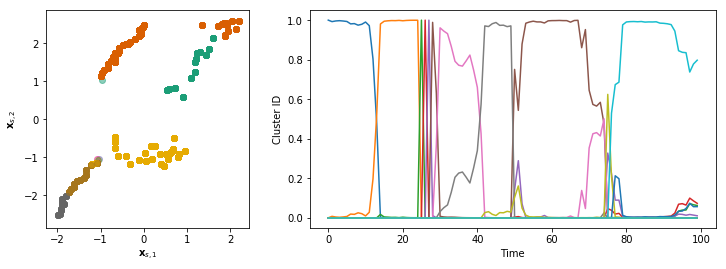

In [37]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### GRU Events

Run SEM: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


Adjusted Mutual Information: 0.8264255720421962
Adjusted Rand Score: 0.886266318537859

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 3 3 3 3 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


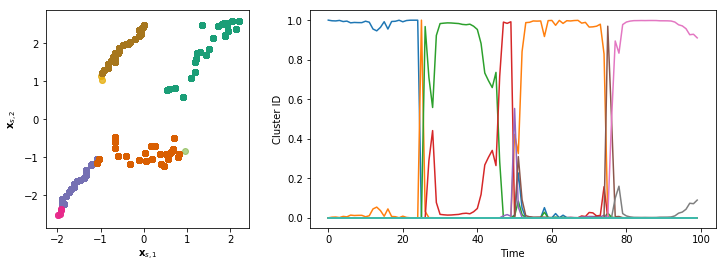

In [38]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

### LSTM Events

Run SEM: 100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Adjusted Mutual Information: 0.7555480703755393
Adjusted Rand Score: 0.7709705830544301

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 3 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1
 1 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


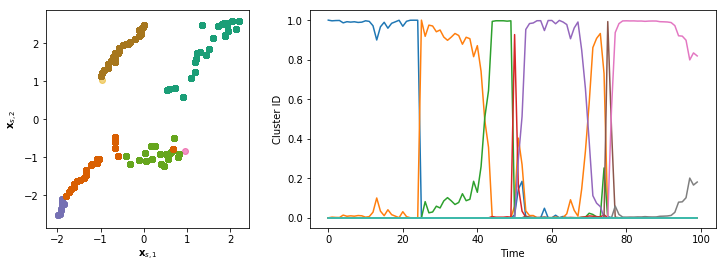

In [39]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train)
tf.Session().close()
plot_segmentation(post, y)

# Linear Dynamical System

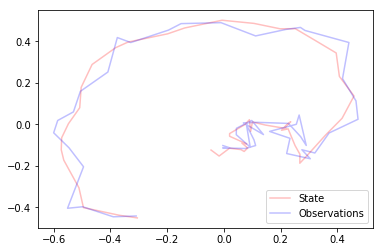

In [40]:
x0 = np.random.rand(2)
def rotate_matrix(theta):
    theta = theta /(180./np.pi)  # convert to radians
    W = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return W

def lds_update(x, A, Q):
    return np.matmul(x, A) + multivariate_normal.rvs(cov=Q)

Q = np.eye(2) * 0.001

x0 = []
x0.append(np.random.randn(2)*0.2)
theta = 4.0 + np.random.randn() * 1.0
b = np.array([-0.4, 1]) + np.random.randn(2) * 0.05
for ii in range(24):
    x0.append(lds_update(x0[-1], rotate_matrix(1), Q))
for ii in range(25):
    x0.append(lds_update(x0[-1], rotate_matrix(-10), Q))

x0 = np.array(x0)
plt.plot(x0[:, 0], x0[:, 1], 'r', alpha=0.25, label='State')

C = np.eye(2) * 0.001
x_train = x0 + multivariate_normal.rvs(cov=C, size=np.shape(x0)[0])
plt.plot(x_train[:, 0], x_train[:, 1], 'b', alpha=0.25, label='Observations')

y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int)])


plt.legend()
# x0

Run SEM: 100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


Adjusted Mutual Information: 0.0
Adjusted Rand Score: 0.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


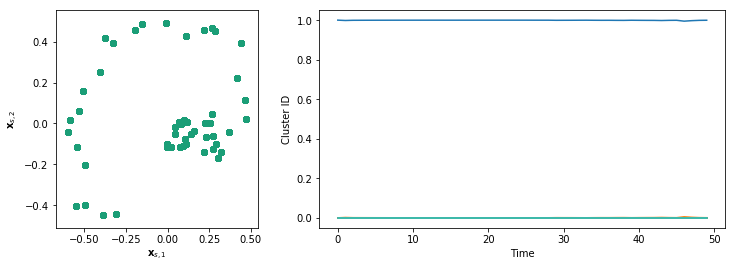

In [41]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train)
tf.Session().close()
plot_segmentation(post, y)